## STUDENT NUMBER: 2360578
### GEMINI-1.5-Pro with txt-03-large embedding model

##### Getting Environment Variables

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
MODEL= "gemini-1.5-pro"

In [2]:
PDF_FILE = "merged_src.pdf"
 
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader(PDF_FILE)
documents = loader.load_and_split()

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
 
splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=200)
 
chunks = splitter.split_documents(documents)

### Load the content in the Vector Store

In [4]:
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(
    chunks, embedding=OpenAIEmbeddings(model="text-embedding-3-large")
)

### Creating a Knowledge Base

In [5]:
import pandas as pd
from giskard.rag import KnowledgeBase


df = pd.DataFrame([d.page_content for d in chunks], columns=["text"])
knowledge_base = KnowledgeBase(df)

### Generate the Test Set

In [6]:
from giskard.rag import QATestset

testset = QATestset.load("fullset-emb-model1-openai.jsonl")

#### Printing the testset

In [7]:
test_set_df = testset.to_pandas()

for index, row in enumerate(test_set_df.head(1).iterrows()):
    print(f"Question {index + 1}: {row[1]['question']}")
    print(f"Reference answer: {row[1]['reference_answer']}")
    print("Reference context:")
    print(row[1]['reference_context'])

Question 1: What is the difference between additive and multiplicative seasonal variation in time series decomposition?
Reference answer: In time series decomposition, additive seasonal variation is when the forecast including trend and seasonal equals Trend plus Seasonal. Multiplicative seasonal variation is when the forecast including trend and seasonal equals Trend times Seasonal factor.
Reference context:
Document 239: Copyright ©2017 McGraw -Hill Education. All rights reserved.
Time Series Decomposition
•Identifying these elements and separating the time series 
data into these components is known as decomposition
•Seasonal variation may be either additive or multiplicative
•Additive:  Forecast including trend and seasonal = Trend + Seasonal
•Multiplicative: Forecast including trend and seasonal = Trend ×Seasonal 
factor
18-30Exhibit 18.9


#### Prepare the prompt template

In [8]:
from langchain.prompts import PromptTemplate

template = """
You are an expert engineering lecturer. Based on provided context, generate a concise and accurate answer to the given question. 
Limit the response to essential details without exceeding token limits, ensuring accuracy. 
If the answer is unknown or unclear, reply with 'I do not know the answer to this question'.

Context: {context}

Question: {question}
"""

prompt = PromptTemplate.from_template(template)
print(prompt.format(context="Here is some context", question="Here is a question"))


You are an expert engineering lecturer. Based on provided context, generate a concise and accurate answer to the given question. 
Limit the response to essential details without exceeding token limits, ensuring accuracy. 
If the answer is unknown or unclear, reply with 'I do not know the answer to this question'.

Context: Here is some context

Question: Here is a question



In [9]:
retriever = vectorstore.as_retriever()

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

model = ChatMistralAI(mistral_api_key='tm0W6ushPJZq7NJOnZXJcmUkHgfp5hGd')
model = ChatGoogleGenerativeAI(model_name="gemini-1.5-pro", api_key=GOOGLE_API_KEY)

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
    }
    | prompt
    | model
    | StrOutputParser()
)

In [12]:
from giskard.rag import AgentAnswer
import time

def answer_fn(question, history=None):
    agent_output = chain.invoke({"question": question})
    time.sleep(3)
    return agent_output

In [ ]:
from giskard.rag import evaluate

report = evaluate(answer_fn, testset=testset, knowledge_base=knowledge_base)

In [14]:
report

Loading BokehJS ...

2024-11-03 12:56:37,347 pid:1192 MainThread giskard.rag  INFO     Finding topics in the knowledge base.
2024-11-03 12:57:03,705 pid:1192 MainThread giskard.rag  INFO     Found 5 topics in the knowledge base.


In [15]:
report.to_html("report-gemini-txt03large.html")

In [16]:
report.correctness_by_question_type()

,correctness
question_type,
complex,0.8
conversational,0.4
distracting element,0.7
double,0.8
simple,0.9
situational,0.8


In [ ]:
df_report = report.to_pandas()
df_gemini = df_report[['question','reference_answer','reference_context','agent_answer']]
df_gemini = df_gemini.rename(columns={
    'reference_answer':'ground_truth',
    'reference_context':'contexts',
    'agent_answer':'answer'

})
df_gemini.reset_index(drop=True)


,question,ground_truth,contexts,answer
0,What is the difference between additive and mu...,"In time series decomposition, additive seasona...",Document 239: Copyright ©2017 McGraw -Hill Edu...,"In time series decomposition, the difference b..."
1,What is the strategy a firm would use to reduc...,The strategy is not specified in the provided ...,Document 143: Copyright ©2017 McGraw -Hill Edu...,"Based on the provided context, a firm can use ..."
2,What is the definition of Takt Time in operati...,Takt Time is the pace of processing to match t...,Document 92: Copyright ©2017 McGraw -Hill Educ...,Takt Time in operations management is the rate...
3,Who holds the copyright for the material on ou...,The copyright for the material on outsourcing ...,Document 135: Copyright ©2017 McGraw -Hill Edu...,The copyright for the material on outsourcing ...
4,What are the five ways an ERP system streamlin...,The five ways an ERP system streamlines hotel ...,"Document 275: 25\nIn the service industry, an ...",An ERP system can streamline hotel and resort ...
5,What are some of the benefits of using eKanban...,eKanban systems reduce inventory which can lea...,Document 178: adjust the system to take into a...,Some benefits of using eKanban systems include...
6,What is the copyright year for the McGraw-Hill...,The copyright year for the McGraw-Hill Educati...,Document 318: Copyright ©2017 McGraw -Hill Edu...,The McGraw-Hill Education materials referenced...
7,What is the Bullwhip Effect in the context of ...,The Bullwhip Effect is a phenomenon of variabi...,Document 127: Copyright ©2017 McGraw -Hill Edu...,"The Bullwhip Effect, in the context of supply ..."
8,What is the copyright year for the McGraw-Hill...,The copyright year for the McGraw-Hill Educati...,Document 318: Copyright ©2017 McGraw -Hill Edu...,The copyright year for the McGraw-Hill Educati...
9,What is the minimally acceptable threshold for...,The minimally acceptable threshold for BOM acc...,Document 259: 11\nAfter the BOM information is...,The minimally acceptable threshold for BOM (Bi...


## RAGAS Evaluation

In [18]:
from datasets import Dataset 
import os
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall

In [19]:
os.environ["RAGAS_DO_NOT_TRACK"] = "true"

In [ ]:
data_samples = {
    'question': df_gemini['question'].tolist(),
    'ground_truth': df_gemini['ground_truth'].tolist(),
    'contexts': df_gemini['contexts'].apply(lambda x: list(x) if isinstance(x, list) else [x]).tolist(),
    'answer': df_gemini['answer'].tolist()
}
dataset = Dataset.from_dict(data_samples)

In [ ]:
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo")

score = evaluate(dataset,llm=llm, metrics=[faithfulness,answer_relevancy,context_precision,context_recall])
df_score = score.to_pandas()

df_score.head(1)

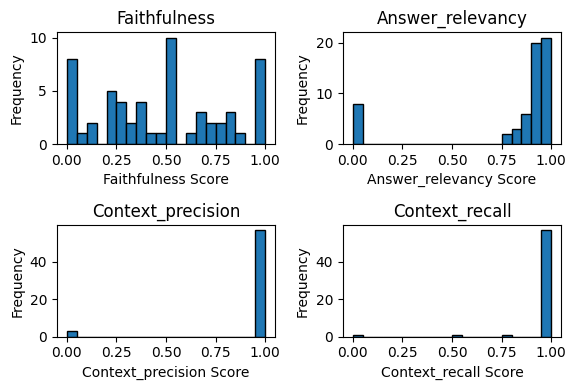

In [ ]:
import matplotlib.pyplot as plt

metrics = ['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall']

num_bins = 20

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(6, 4))

axes = axes.flatten()

for i, metric in enumerate(metrics):
    axes[i].hist(df_score[metric], bins=num_bins, edgecolor='black')
    axes[i].set_title(metric.capitalize())
    axes[i].set_xlabel(f'{metric.capitalize()} Score')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [24]:
df_score.isnull().sum()
import numpy as np
df_score= df_score.replace(np.nan, 0)


### Creating an Inspector RAGet Report

In [25]:
name = "Ragas for Gemini-1.5-pro with Text-03-large Embeddings"
models = [
    {
        "model_id": "GoogleGenerativeAI/Gemini-1.5-pro/txt-03-large",
        "name": "Gemini-1.5-pro/txt-03-large",
        "owner": "GoogleGenerativeAI"
    }
]

In [26]:
all_metrics = [
    {
        "name": "faithfulness",
        "display_name": "Faithfulness",
        "description": "Faithfulness",
        "author": "algorithm",
        "type": "numerical",
        "aggregator": "average",
        "range": [0, 1.0, 0.1]
    },
    {
        "name": "answer_relevancy",
        "display_name": "Answer Relevancy",
        "description": "Answer Relevancy",
        "author": "algorithm",
        "type": "numerical",
        "aggregator": "average",
        "range": [0, 1.0, 0.1]
    },
    {
        "name": "context_precision",
        "display_name": "Context Precision",
        "description": "Context Precision",
        "author": "algorithm",
        "type": "numerical",
        "aggregator": "average",
        "range": [0, 1.0, 0.1]
    },
    {
        "name": "context_recall",
        "display_name": "Context Recall",
        "description": "Context Recall",
        "author": "algorithm",
        "type": "numerical",
        "aggregator": "average",
        "range": [0, 1.0, 0.1]
    }
]

In [27]:
doc_id_counter = 0

doc_text_to_id = {}
for index, row in df_score.iterrows():
    for c in row["retrieved_contexts"]:
        if c not in doc_text_to_id:
            doc_text_to_id[c] = doc_id_counter
            doc_id_counter += 1

In [28]:
all_documents = []
all_tasks = []
all_evaluations = []

# Populate documents
for doc_text, doc_id in doc_text_to_id.items():
    document = {
        "document_id": f"{doc_id}",
        "text": f"{doc_text}"
    }
    all_documents.append(document)

# Populate taks and evaluations
for index, row in df_score.iterrows():
    instance = {
        "task_id": f"{index}",
        "task_type": "rag",
        "contexts": [ {"document_id": f"{doc_text_to_id[c]}"} for c in row["retrieved_contexts"] ],
        "input": [{"speaker": "user", "text": f"{row['user_input']}"}],
        "targets": [{"text": f"{row['reference']}"}]
    }
    all_tasks.append(instance)

    evaluation = {
        "task_id": f"{index}",
        "model_id": f"{models[0]['model_id']}",
        "model_response": f"{row['response']}",
        "annotations": {}
    }
    for metric in all_metrics:
        metric_name = metric["name"]
        evaluation["annotations"][metric_name] = {
            "system": {
                "value": row[metric_name],
                "duration": 0
            }
        }
    all_evaluations.append(evaluation)

In [29]:
import json

output = {
    "name": name,
    "models": models,
    "metrics": all_metrics,
    "documents": all_documents,
    "tasks": all_tasks,
    "evaluations": all_evaluations,
}

with open(
    file="ragas-inspectorraget-Gemini-txt03large.json", mode="w", encoding="utf-8"
) as fp:
    json.dump(output, fp, indent=4)